<a href="https://colab.research.google.com/github/artms-18/computer-vision-bootcamp/blob/master/CIFAR10_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computer Vision using a ResNet50 model on the CIFAR10 dataset.

In [ ]:
#importing required libraries

import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import pickle
import tarfile
import numpy as np
import cv2

from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, Activation, Add
from keras.layers import Input, AveragePooling2D
from keras.models import Model
import tensorflow_datasets as tfds


In [ ]:
#checking if connected to GPU runtime

!nvidia-smi

Sat Jun 19 17:05:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# getting the CIFAR-10 dataset from the built-in tensorflow dataset module

(training_images, training_labels), (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
#preprocessing tha CIFAR-10 dataset using the built in preprocessing function

def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

## The ResNet50 Model

Essentially what is does, is use a series of residual blocks (which take an original input, do some convolutions and then add the original input to the updated one) and stacks them on top of each other, while also reducing the dimensionality of the input every few blocks. It is used to aid in backpropagation wherein usually, there is a vanishing gradient problem, however, the residual blocks help alleviate this issue.

Also, I would usually just use tranfer learning to get the model but I feel like thats cheating haha so I just built my own

In [ ]:
# Creating a data augmentation layer that will be incorporated into the model (aids in reducing overfitting)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal")
], name = 'data_augmentation')

In [ ]:
# First define the identity block, where the dimension des not change, but the depth does.
# Following the stucture of the ResNet50 model

def identity(input, filters):

  """

  Args:  
    input: the input passed from a previous layer (using the tensorflow functional API)
    filters: a tuple containing the respective number of filters being applied in the convolutions

  Returns: an output 'x' of which will be passed to another layers within the model

  """

  skip = input
  filter1, filter2 = filters

  #first block
  x = Conv2D(filter1, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = regularizers.l2(0.001))(input)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block (size is kept the same with padding = 'same')
  x = Conv2D(filter1, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer = regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block 
  x = Conv2D(filter2, kernel_size= (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)

  #add the input
  x = Add()([x, skip])
  x = Activation(activations.relu)(x)

  return x


In [ ]:
def res_conv(input, strides, filters):

  """
  Args:
    
    input: the input passed from a previous layer
    strides: how far the filter moves before being applied again 
    filters: a tuple containing the number of conv filters being applied to the input
  

  Returns:

    an output with reduced dimensionality of the input shape /2 (following the ResNet50 structure)

  """

  skip = input
  filter1, filter2 = filters

  #first block
  x = Conv2D(filter1, kernel_size = (1,1), strides = (strides, strides), padding = 'valid', kernel_regularizer=regularizers.l2(0.001))(input)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #second block
  x = Conv2D(filter1, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_regularizer= regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)

  #third block
  x = Conv2D(filter2, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_regularizer = regularizers.l2(0.001))(x)
  x = BatchNormalization()(x)
  
  #converting the input tensor to match the dimensionality of the newly changed x (due to changing the strides)
  skip = Conv2D(filter2, kernel_size = (1,1), strides = (strides, strides), padding = 'valid', kernel_regularizer = regularizers.l2(0.001))(skip)
  skip = BatchNormalization()(skip)

  #add
  x = Add()([x, skip])
  x = Activation(activations.relu)(x)

  return x


In [ ]:
# finally building the ResNet Model!!

from keras.layers import Input, AveragePooling2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.models import Model
from keras import activations, regularizers


def resnet50():

  """

  Args: None

  Returns: the ResNet50 tensorflow model

  """

  input_image = Input(shape = (32,32,3)) #the way images in CIFAR dataset are stuctured
  resize = UpSampling2D(size=(7,7))(input_image)
  x = data_augmentation(resize)
  x = ZeroPadding2D(padding = (3,3))(x) #to preserve original input size

  #step 1: maxpooling (refer to model summary of ResNet50)

  #images are scaled to 256x256
  x = Conv2D(64, kernel_size = (7,7), strides = (2,2))(x)
  x = BatchNormalization()(x)
  x = Activation(activations.relu)(x)
  x = MaxPooling2D((3,3), strides = (2,2))(x)

  #step 2:

  x = res_conv(x, strides = 1, filters = (64, 256))
  x = identity(x, filters=(64, 256))
  x = identity(x, filters = (64,256))

  #step 3:

  x = res_conv(x, strides = 2, filters = (128, 512))
  x = identity(x, filters = (128, 512))
  x = identity(x, filters = (128, 512))
  x = identity(x, filters = (128, 512))

  #step 4

  x = res_conv(x, strides = 2, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))
  x = identity(x, filters = (256, 1024))

  #step 5

  x = res_conv(x, strides = 2, filters = (512, 2048))
  x = identity(x, filters = (512, 2048))
  x = identity(x, filters = (512, 2048))

  #model concludes with average pooling and dense connection

  x = AveragePooling2D((2,2), padding = 'same')(x)

  #add a flatten layer as dense required this input shape
  x = Flatten()(x)
  x = Dense(10, activation = 'softmax', kernel_initializer = tf.keras.initializers.he_normal)(x)

  model = Model(inputs = input_image, outputs = x, name = 'Resnet50')

  return model


In [ ]:
model = resnet50()

In [ ]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.image.random_flip_left_right (None, 224, 224, 3)  0           up_sampling2d_1[0][0]            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           tf.image.random_flip_left_right[0
___________________________________________________________________________________________

In [ ]:
from tensorflow.keras.utils import plot_model

#plot_model(model, show_shapes = True)

## Callback

In [ ]:
#defining a callback class
#using earlystopping 
#it basically uses a moving average to see if the loss decreases in the future and stops training if it dosen't, saving the best weights

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing."""
    def on_epoch_end(self, epoch, logs=None): #is called at the end of each epoch
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

earlyStopping = EarlyStoppingAtMinLoss()

## Compiling and Fitting the model

In [ ]:
# preparing the data in tensorflow datasets for accelerated training

train_data = tf.data.Dataset.from_tensor_slices((training_images, training_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#defining the loss, optimizer, and metrics used for compiling the model 

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [ ]:
#training the model to fit the data over 50 epochs

model_history = model.fit(train_data, epochs = 50, validation_data = val_data, callbacks = [earlyStopping])

Epoch 1/50
1563/1563 [==============================] - 269s 172ms/step - loss: 13.9584 - accuracy: 0.5880 - val_loss: 12.1135 - val_accuracy: 0.5877
Epoch 2/50
1563/1563 [==============================] - 269s 172ms/step - loss: 10.2743 - accuracy: 0.6601 - val_loss: 8.7655 - val_accuracy: 0.6480
Epoch 3/50
1563/1563 [==============================] - 269s 172ms/step - loss: 7.4225 - accuracy: 0.7112 - val_loss: 6.5224 - val_accuracy: 0.6801
Epoch 4/50
1563/1563 [==============================] - 269s 172ms/step - loss: 5.5088 - accuracy: 0.7496 - val_loss: 5.0712 - val_accuracy: 0.7038
Epoch 5/50
1563/1563 [==============================] - 269s 172ms/step - loss: 4.2636 - accuracy: 0.7751 - val_loss: 3.9283 - val_accuracy: 0.7353
Epoch 6/50
1563/1563 [==============================] - 269s 172ms/step - loss: 3.3801 - accuracy: 0.8115 - val_loss: 3.2179 - val_accuracy: 0.7611
Epoch 7/50
1563/1563 [==============================] - 269s 172ms/step - loss: 2.7787 - accuracy: 0.8261 - v

In [ ]:
 model.save("mikas_model")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: mikas_model/assets


In [ ]:
from google.colab import files
files.download('mikas_model/saved_model.pb') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(metric_name, title, ylim=1):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)
  plt.savefig('acc_per_epoch.png')

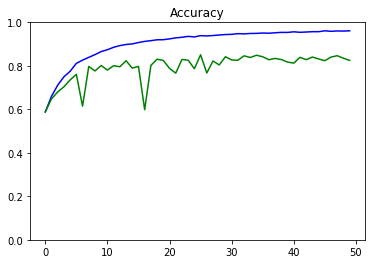

In [ ]:
plot_metrics('accuracy', 'Accuracy')

Evidently, the training was a bit wonky at first, but calmed down after about 30 epochs a began to overfit at around the same place, so in retrospect, the model works best at around 30 epochs with an accuracy of about 94%